Our model is forced by offline dynamics in 2002 for 6 times. This notebook displays our model results.

In [2]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import copy
import os
import glob
import pylab as pl
import numpy as np
import matplotlib.animation as animation
import types
from mpl_toolkits.basemap import cm,addcyclic,Basemap, shiftgrid
% matplotlib inline

nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/tracer6/newsms/fse3t_based_mask/2002Eplus1to6.nc'))#*_ptrc_T*.nc'))
print("found *.nc file: \n{}".format(nc_filename))

found *.nc file: 
['/ocean/xiaoxiny/research/result_jasper/tracer6/newsms/fse3t_based_mask/2002Eplus1to6.nc']


In [3]:
ptrc=nc.Dataset(nc_filename[0])

lon=ptrc.variables['nav_lon'][:]
lat=ptrc.variables['nav_lat'][:]
dep = ptrc.variables['deptht'][:]




bathy=nc.Dataset(
    '/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy=bathy.variables['Bathymetry']


In [4]:
#take a look at the time dimension
diss=ptrc.variables['TR_7'][:,0,0,0]
tlen=diss.shape
print tlen[0]

72


### Focus on the time evolution

In [61]:
def readdata(phase,string,i,x,y):
    if string =='Pa':
        if phase =='diss':
            data=ptrc.variables['TR_7'][:,i,x,y]
        else:
            data=ptrc.variables['TR_9'][:,i,x,y]
    else:
        if phase =='diss':
            data=ptrc.variables['TR_8'][:,i,x,y]
        else:
            data=ptrc.variables['TR_10'][:,i,x,y]
    data=np.ma.masked_where(data<=0,data)
    return data

def readice(string,i,x,y):
    if string =='Pa':
            data=ptrc.variables['TR_11'][:,i,x,y]
    else:
            data=ptrc.variables['TR_12'][:,i,x,y]
    if string =='deso':
        Dsopt=nc.Dataset('/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/myANHA/EXP00/data_Th_desorption_rate.nc')
        data=Dsopt.variables['desorption_rate'][:,x,y]
    data=np.ma.masked_where(data<=0,data)
    return data

def analy(string,phase,i,loc,ice):
        if string=='Pa':
            k=-0.0005*100*ice+0.06
            if phase=='part':
                analy=0.00246/(6.01*100*ice+500)*dep[i]
            else:
                analy=0.00246/k+0.31/k*0.00246/(6.01*100*ice+500)*dep[i]
        if string=='Th':
            k=-0.0067*100*ice+0.75
            if phase=='part':
                analy=0.0267/(2.26*100*ice+500)*dep[i]
            else:
                k_1=readice('deso',i,x[loc],y[loc])
                analy=0.0267/k+k_1/k*0.0267/(2.26*100*ice+500)*dep[i]
        return analy
                
def tracer_evolution(ptrc,j,string,name):
    

    
    fig = plt.figure(figsize=(20,10))
    gs = gridspec.GridSpec(3, 3)
    ax = fig.add_subplot(gs[0:2,0])
    m = Basemap(projection='npstere',boundinglat=65,lon_0=0,resolution='l')
    m.drawcoastlines()
    m.fillcontinents(color = '0.75')
    m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
    m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])
    x_lon,y_lat = m(lon,lat)
    plt.plot(x_lon[::10,::10],y_lat[::10,::10],x_lon.T[::10,::10],y_lat.T[::10,::10],color='k',linewidth=0.1)
    #x=[700,630,600]
    #y=[200,300,350]
    #c=['orange','red','cyan']
    m.scatter(x_lon[x,y],y_lat[x,y],color=c,s=40)
    m = m.contour(x_lon,y_lat,bathy,linewidth=0.075,colors='black',alpha=0.4)
    plt.clabel(m, fontsize=10, inline=1,fmt = '%1.0f')

    ax = fig.add_subplot(gs[0,1])
    i=j[0]
    for loc in range (len(x)):
        data=readdata('diss',string,i,x[loc],y[loc])
        plt.plot(data,color=c[loc],linestyle='-',lw='2',label=('simulation'))
        ice=readice(string,i,x[loc],y[loc])
        ana=analy(string,'diss',i,loc,ice)
        plt.plot(ana,color=c[loc],linestyle='--',lw='2',label=('analytical'))
        #print ana
    plt.ylabel('Tracer concentration (dpm/m$^{3}$)')
    plt.title('%s'%(name[0]))
    ax.annotate('Depth: %sm'%dep[i], xy=(1, 0.8), xycoords='axes fraction', fontsize=11,
                xytext=(-5, 5), textcoords='offset points',
                ha='right', va='bottom')

    for num in range (tlen[0]/12):
        plt.axvline(x=(num+1)*12-1,ls=':')
    plt.xlim([0,tlen[0]-1])
    
    ax = fig.add_subplot(gs[0,2])      
    for loc in range (len(x)):
        data=readdata('part',string,i,x[loc],y[loc])
        plt.plot(data,color=c[loc],linestyle='-',lw='2',label=('analytical'))
        ice=readice(string,i,x[loc],y[loc])
        ana=analy(string,'part',i,loc,ice)
        plt.plot(ana,color=c[loc],linestyle='--',lw='2',label=('analytical'))
    plt.ylabel('Tracer concentration (dpm/m$^{3}$)')
    plt.title('%s'%(name[1]))
    ax.annotate('Depth: %sm'%dep[i], xy=(1, 0.8), xycoords='axes fraction', fontsize=11,
                xytext=(-5, 5), textcoords='offset points',
                ha='right', va='bottom')
    for num in range (tlen[0]/12):
        plt.axvline(x=(num+1)*12-1,ls=':')
    plt.xlim([0,tlen[0]-1])
    
    ax = fig.add_subplot(gs[1,1])
    i=j[1]
    for loc in range (len(x)):
        data=readdata('diss',string,i,x[loc],y[loc])
        plt.plot(data,color=c[loc],linestyle='-',lw='2',label=('simulation'))
        ice=readice(string,i,x[loc],y[loc])
        ana=analy(string,'diss',i,loc,ice)
        plt.plot(ana,color=c[loc],linestyle='--',lw='2',label=('analytical'),alpha=0.8)
    plt.ylabel('Tracer concentration (dpm/m$^{3}$)')
    ax.annotate('Depth: %sm'%dep[i], xy=(1, 0.8), xycoords='axes fraction', fontsize=11,
                xytext=(-5, 5), textcoords='offset points',
                ha='right', va='bottom')
    #plt.legend(loc=0,fontsize=11)
    for num in range (tlen[0]/12):
        plt.axvline(x=(num+1)*12-1,ls=':')
    plt.xlim([0,tlen[0]-1])

    ax = fig.add_subplot(gs[1,2])
    for loc in range (len(x)):
        data=readdata('part',string,i,x[loc],y[loc])
        plt.plot(data,color=c[loc],linestyle='-',lw='2',label=('simulation'))
        ice=readice(string,i,x[loc],y[loc])
        ana=analy(string,'part',i,loc,ice)
        plt.plot(ana,color=c[loc],linestyle='--',lw='2',label=('analytical'),alpha=0.8)
    plt.ylabel('Tracer concentration (dpm/m$^{3}$)')
    ax.annotate('Depth: %sm'%dep[i], xy=(1, 0.8), xycoords='axes fraction', fontsize=11,
                xytext=(-5, 5), textcoords='offset points',
                ha='right', va='bottom')
    #plt.legend(loc=0,fontsize=11)
    for num in range (tlen[0]/12):
        plt.axvline(x=(num+1)*12-1,ls=':')
    plt.xlim([0,tlen[0]-1])
    
    
    ax = fig.add_subplot(gs[2,1])
    i=j[2]
    for loc in range (len(x)):
        data=readdata('diss',string,i,x[loc],y[loc])
        plt.plot(data,color=c[loc],linestyle='-',lw='2',label=('simulation'))
        ice=readice(string,i,x[loc],y[loc])
        ana=analy(string,'diss',i,loc,ice)
        plt.plot(ana,color=c[loc],linestyle='--',lw='2',label=('analytical'),alpha=0.8)
    plt.xlabel('Time step (month)')
    plt.ylabel('Tracer concentration (dpm/m$^{3}$)')
    ax.annotate('Depth: %sm'%dep[i], xy=(1, 0.8), xycoords='axes fraction', fontsize=11,
                xytext=(-5, 5), textcoords='offset points',
                ha='right', va='bottom')
    #plt.legend(loc=0,fontsize=11)
    for num in range (tlen[0]/12):
        plt.axvline(x=(num+1)*12-1,ls=':')
    plt.xlim([0,tlen[0]-1])

    ax = fig.add_subplot(gs[2,2])
    for loc in range (len(x)):
        data=readdata('part',string,i,x[loc],y[loc])
        plt.plot(data,color=c[loc],linestyle='-',lw='2',label=('simulation'))
        ice=readice(string,i,x[loc],y[loc])
        ana=analy(string,'part',i,loc,ice)
        plt.plot(ana,color=c[loc],linestyle='--',lw='2',label=('analytical'),alpha=0.8)
    plt.xlabel('Time step (month)')
    plt.ylabel('Tracer concentration (dpm/m$^{3}$)')
    ax.annotate('Depth: %sm'%dep[i], xy=(1, 0.8), xycoords='axes fraction', fontsize=11,
                xytext=(-5, 5), textcoords='offset points',
                ha='right', va='bottom')
    for num in range (tlen[0]/12):
        plt.axvline(x=(num+1)*12-1,ls=':')
    plt.xlim([0,tlen[0]-1])
    #plt.legend(loc=0,fontsize=11)
    plt.show()

# 2002-2007

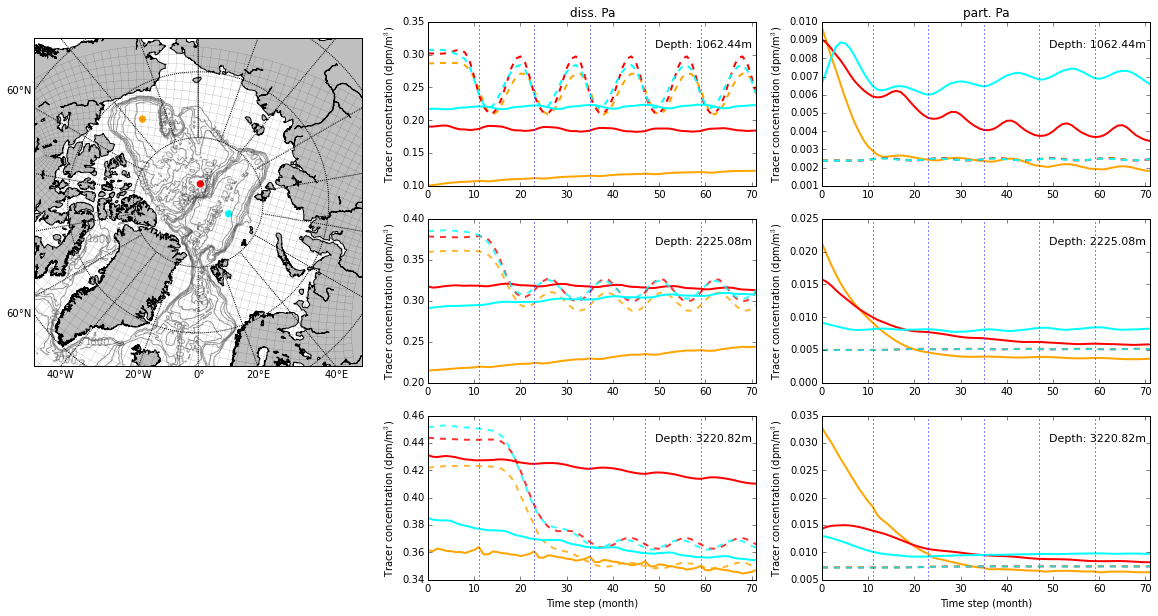

In [62]:
from matplotlib import gridspec
x=[700,630,600]
y=[200,300,350]
c=['orange','red','cyan']
ptrc=nc.Dataset(nc_filename[0])
tracer_evolution(ptrc,j=[35,40,43],string='Pa',name=['diss. Pa','part. Pa'])

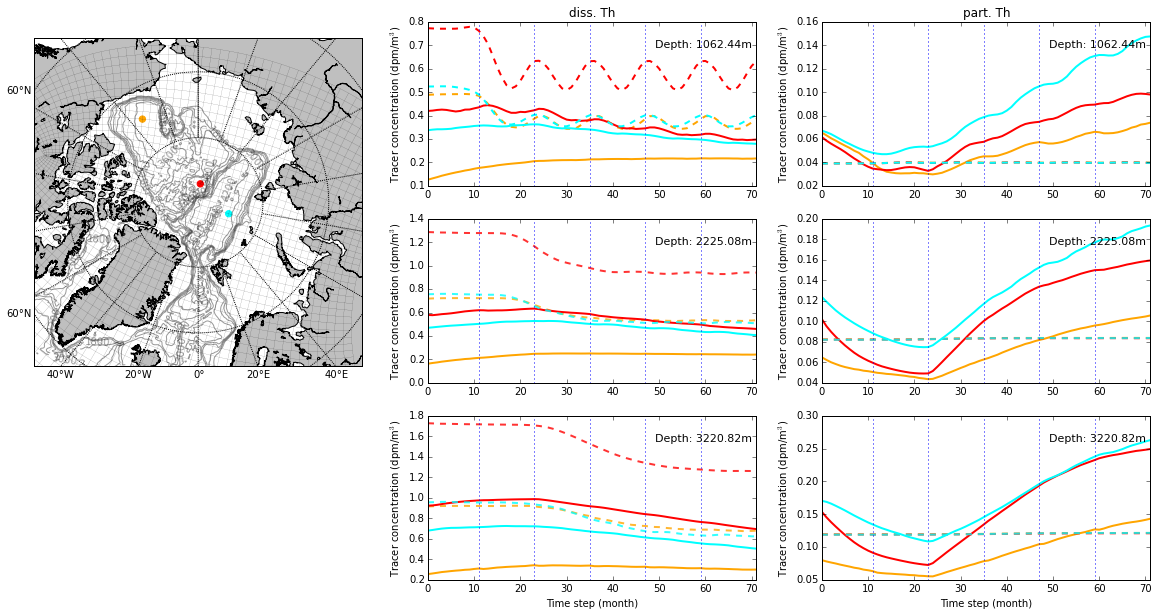

In [63]:
x=[700,630,600]
y=[200,300,350]
c=['orange','red','cyan']
ptrc=nc.Dataset(nc_filename[0])
tracer_evolution(ptrc,j=[35,40,43],string='Th',name=['diss. Th','part. Th'])

### Horiz. and Vert. Profiles

In [8]:
def readice(string,i,a1,a2,b1,b2):
    if string =='icePa':
            if i==0:
                data=ptrc.variables['TR_11'][:,:,a1:a2,b1:b2]
            else:
                data=ptrc.variables['TR_11'][:,i,a1:a2,b1:b2]
    else:

            if i==0:
                data=ptrc.variables['TR_12'][:,:,a1:a2,b1:b2]
            else:
                data=ptrc.variables['TR_12'][:,i,a1:a2,b1:b2]
    data=np.ma.masked_where(data<=0,data)
    return data

In [9]:
#write a function to read data
def readdata(phase,string,i,a1,a2,b1,b2):
    if string =='Pa':
        if phase =='diss':
            if i==0:
                data=ptrc.variables['TR_7'][:,:,a1:a2,b1:b2]
            else:
                data=ptrc.variables['TR_7'][:,i,a1:a2,b1:b2]
        else:
            if i==0:
                data=ptrc.variables['TR_9'][:,:,a1:a2,b1:b2]
            else:
                data=ptrc.variables['TR_9'][:,i,a1:a2,b1:b2]
    else:
        if phase =='diss':
            if i==0:
                data=ptrc.variables['TR_8'][:,:,a1:a2,b1:b2]
            else:
                data=ptrc.variables['TR_8'][:,i,a1:a2,b1:b2]
        else:
            if i==0:
                data=ptrc.variables['TR_10'][:,:,a1:a2,b1:b2]
            else:
                data=ptrc.variables['TR_10'][:,i,a1:a2,b1:b2]
    data=np.ma.masked_where(data<=0,data)
    return data

In [10]:
# write a function to plot data
def plot_ratio(string,title,data):
    fig = plt.figure(figsize=(20,20))

    for num in range (tlen[0]/12):
        ax1 = fig.add_subplot(5,3,num+1)
        #m = Basemap(projection='npstere',boundinglat=65,lon_0=0,resolution='l',ax=ax1)
        m = Basemap(width =3345532*1,height =950905*2.2,lon_0=-160, lat_0=75,
                        projection='stere', resolution='l',ax=ax1)
        m.drawcoastlines()
        m.fillcontinents(color = '0.75')
        m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
        m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])
        x_lon,y_lat = m(lon,lat)
        m.plot(x_lon[::10,::10],y_lat[::10,::10],x_lon.T[::10,::10],y_lat.T[::10,::10],color='k',linewidth=0.1)
        if num==0:
            im = m.pcolor(x_lon[a1:a2,b1:b2],y_lat[a1:a2,b1:b2],data[1,:,:],vmin=vmin,vmax=vmax)
        else:
            im = m.pcolor(x_lon[a1:a2,b1:b2],y_lat[a1:a2,b1:b2],data[(num+1)*12-1,:,:],vmin=vmin,vmax=vmax)

        plt.colorbar(im, ax = ax1, fraction=0.03,pad=0.02)
        x=[700,630,600]
        y=[200,300,350]
        c=['orange','red','cyan']
        m.scatter(x_lon[x,y],y_lat[x,y],c=c,s=40)
        plt.title('Horizontal profile for%s. %s (%s yr)'%(string,title,num),fontsize=10)

    plt.show()
    
    
def plot_ratio2(string,title,data):
    fig = plt.figure(figsize=(20,20))

    for num in range (tlen[0]/12):
        ax1 = fig.add_subplot(5,3,num+1)
        #m = Basemap(projection='npstere',boundinglat=65,lon_0=0,resolution='l',ax=ax1)
        m = Basemap(width =3345532*1,height =950905*2.2,lon_0=0, lat_0=85,
                        projection='stere', resolution='l',ax=ax1)
        m.drawcoastlines()
        m.fillcontinents(color = '0.75')
        m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
        m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])
        x_lon,y_lat = m(lon,lat)
        m.plot(x_lon[::10,::10],y_lat[::10,::10],x_lon.T[::10,::10],y_lat.T[::10,::10],color='k',linewidth=0.1)
        if num==0:
            im = m.pcolor(x_lon[a1:a2,b1:b2],y_lat[a1:a2,b1:b2],data[1,:,:],vmin=vmin,vmax=vmax)
        else:
            im = m.pcolor(x_lon[a1:a2,b1:b2],y_lat[a1:a2,b1:b2],data[(num+1)*12-1,:,:],vmin=vmin,vmax=vmax)
        plt.colorbar(im, ax = ax1, fraction=0.03,pad=0.02)
        x=[700,630,600]
        y=[200,300,350]
        c=['orange','red','cyan']
        m.scatter(x_lon[x,y],y_lat[x,y],c=c,s=40)
        plt.title('Horizontal profile for%s. %s (%s yr)'%(string,title,num),fontsize=10)

    plt.show()

In [11]:
def plot_vertical(lat,data1, title1,vmin,vmax,lmin=30,lmax=46,ylim=[0,4005]):
    fig = plt.figure(figsize=(20,25))
    for num in range (tlen[0]/12):
        ax = fig.add_subplot(5,3,num+1)
        #print lat.shape,dep[lmin:lmax].shape,data1.shape,data1[num,lmin:lmax,0,:].shape
        if num==0:
            plt.pcolor(lat[:],dep[lmin:lmax],data1[1,lmin:lmax,0,:],vmin=vmin,vmax=vmax,alpha=0.5)
        else:
            plt.pcolor(lat[:],dep[lmin:lmax],data1[(num+1)*12-1,lmin:lmax,0,:],vmin=vmin,vmax=vmax,alpha=0.5)
        plt.colorbar()
        plt.ylim(ylim)
        plt.gca().invert_yaxis()
        plt.ylabel('Depth (m)')
        plt.xlabel('Lat')
        plt.title('%s (%s yr)'%(title1,num))
        plt.axhline(y=1062,c="blue",linewidth=2,alpha=0.5)
        plt.axhline(y=2225,c="blue",linewidth=2,alpha=0.5)
        plt.axhline(y=3220,c="blue",linewidth=2,alpha=0.5)
    plt.show()

### investigate the ratio of diss/part 231pa/230th

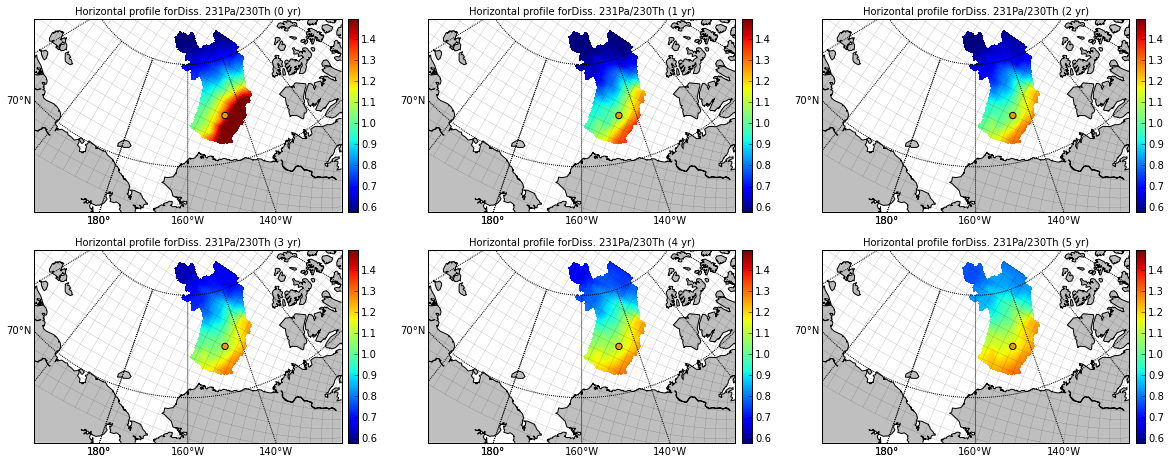

In [12]:
a1=640
a2=800
b1=0
b2=300
layer=44

data1=readdata('diss','Pa',layer,a1,a2,b1,b2)
data2=readdata('diss','Th',layer,a1,a2,b1,b2)

data=data1[:,:,:]/data2[:,:,:]

vmax=0.7*(data1[:,:,:]/data2[:,:,:]).max()
vmin=1.2*(data1[:,:,:]/data2[:,:,:]).min()

plot_ratio('Diss','231Pa/230Th',data)

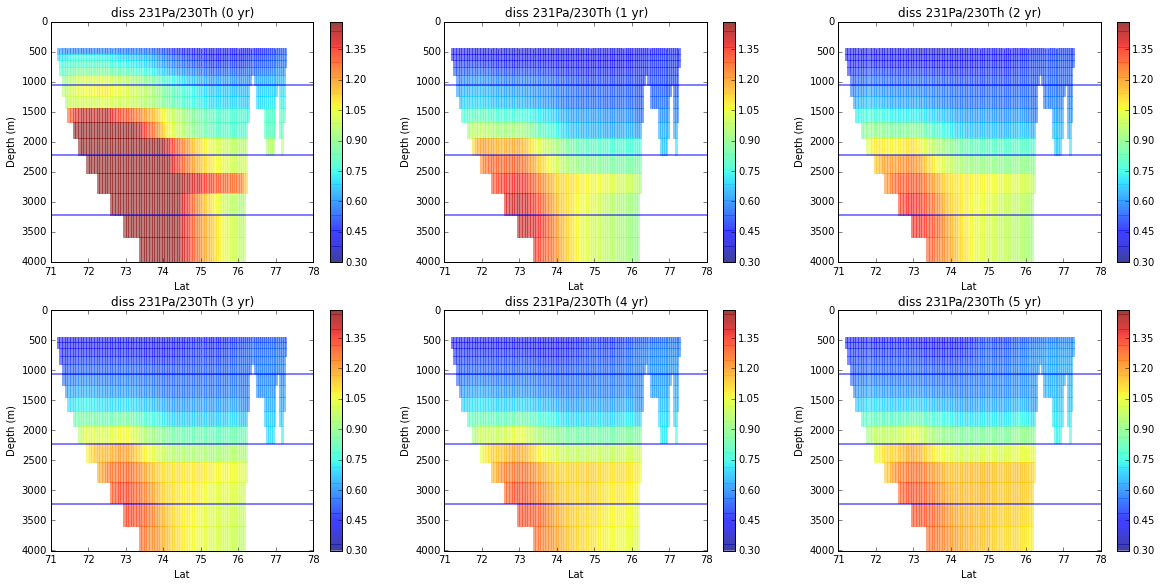

In [13]:
#plot vertical profiles
data1=readdata('diss','Pa',i=0,a1=700,a2=701,b1=150,b2=250)
data2=readdata('diss','Th',i=0,a1=700,a2=701,b1=150,b2=250)
data=data1[:]/data2[:]

vmax=0.6*(data[:]).max()
vmin=1.2*(data[:]).min()

plot_vertical(lat=lat[700,150:250],data1=data, title1='diss 231Pa/230Th',vmin=vmin,vmax=vmax)

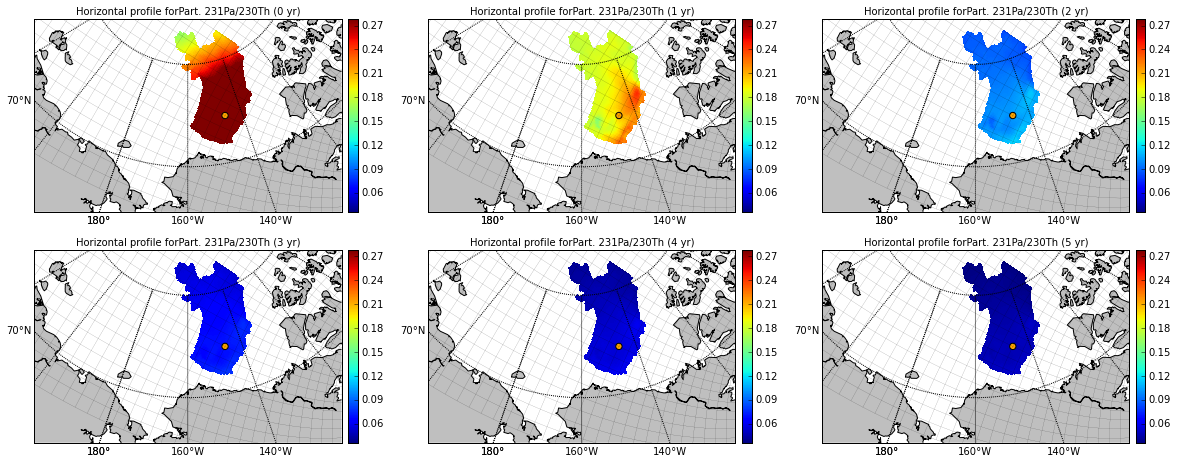

zoom in the 3rd and the 4th year


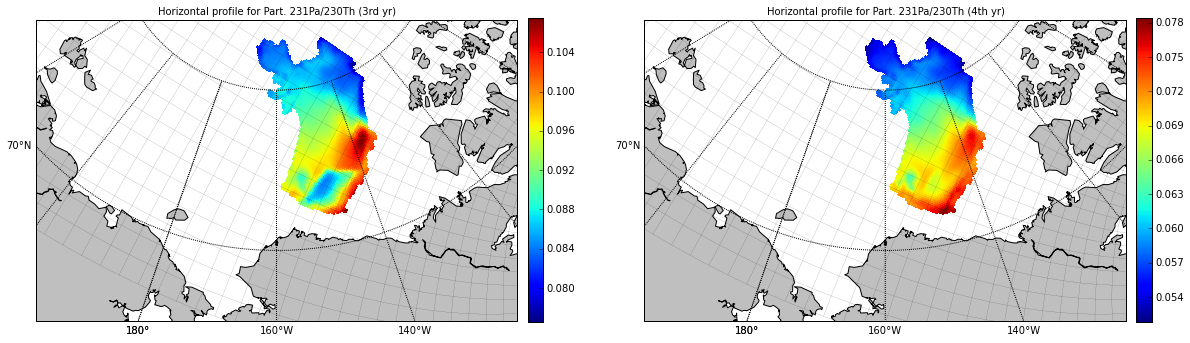

In [14]:
data1=readdata('part','Pa',layer,a1,a2,b1,b2)
data2=readdata('part','Th',layer,a1,a2,b1,b2)


data=data1/data2
vmax=0.5*(data).max()
vmin=1*(data).min()


plot_ratio('Part','231Pa/230Th',data)


print 'zoom in the 3rd and the 4th year'
string = 'Part'
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
m = Basemap(width =3345532*1,height =950905*2.2,lon_0=-160, lat_0=75,
                projection='stere', resolution='l',ax=ax1)
m.drawcoastlines()
m.fillcontinents(color = '0.75')
m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])
x_lon,y_lat = m(lon,lat)
m.plot(x_lon[::10,::10],y_lat[::10,::10],x_lon.T[::10,::10],y_lat.T[::10,::10],color='k',linewidth=0.1)
im = m.pcolor(x_lon[a1:a2,b1:b2],y_lat[a1:a2,b1:b2],data[36,:,:])
plt.colorbar(im, ax = ax1, fraction=0.03,pad=0.02)
plt.title('Horizontal profile for %s. 231Pa/230Th (3rd yr)'%string,fontsize=10)

ax1 = fig.add_subplot(122)
m = Basemap(width =3345532*1,height =950905*2.2,lon_0=-160, lat_0=75,
                projection='stere', resolution='l',ax=ax1)
m.drawcoastlines()
m.fillcontinents(color = '0.75')
m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])
x_lon,y_lat = m(lon,lat)
m.plot(x_lon[::10,::10],y_lat[::10,::10],x_lon.T[::10,::10],y_lat.T[::10,::10],color='k',linewidth=0.1)
im = m.pcolor(x_lon[a1:a2,b1:b2],y_lat[a1:a2,b1:b2],data[47,:,:])
plt.colorbar(im, ax = ax1, fraction=0.03,pad=0.02)
plt.title('Horizontal profile for %s. 231Pa/230Th (4th yr)'%string,fontsize=10)
plt.show()

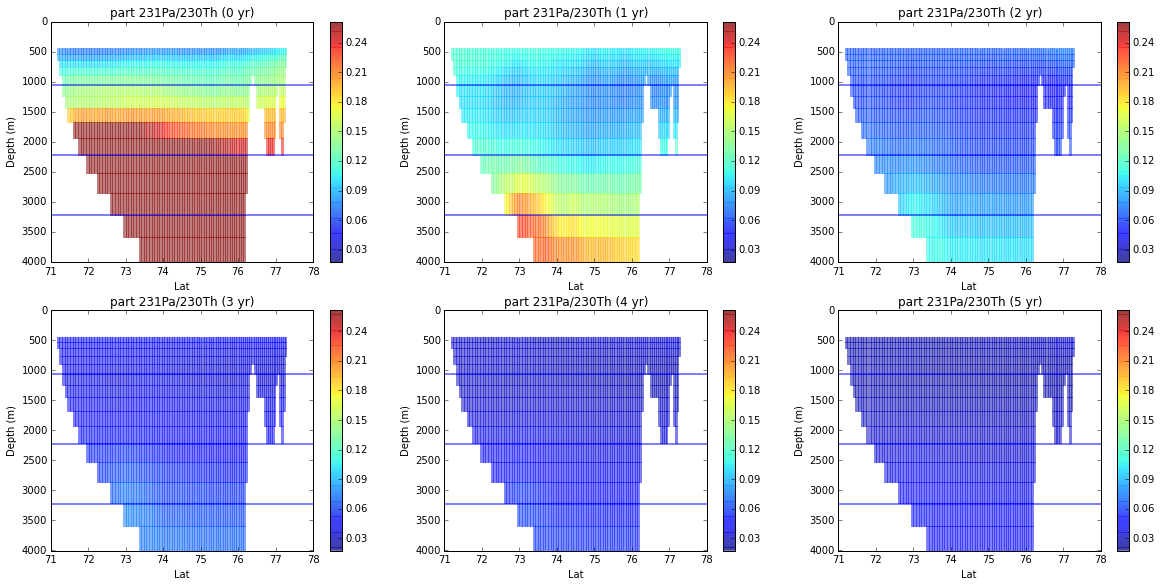

In [15]:
#plot vertical profiles
data1=readdata('part','Pa',i=0,a1=700,a2=701,b1=150,b2=250)
data2=readdata('part','Th',i=0,a1=700,a2=701,b1=150,b2=250)
data=data1[:]/data2[:]

vmax=0.5*(data[:]).max()
vmin=1*(data[:]).min()

plot_vertical(lat=lat[700,150:250],data1=data, title1='part 231Pa/230Th',vmin=vmin,vmax=vmax)

## Ice (Useful in understanding the tracer profiles below)

1.05753


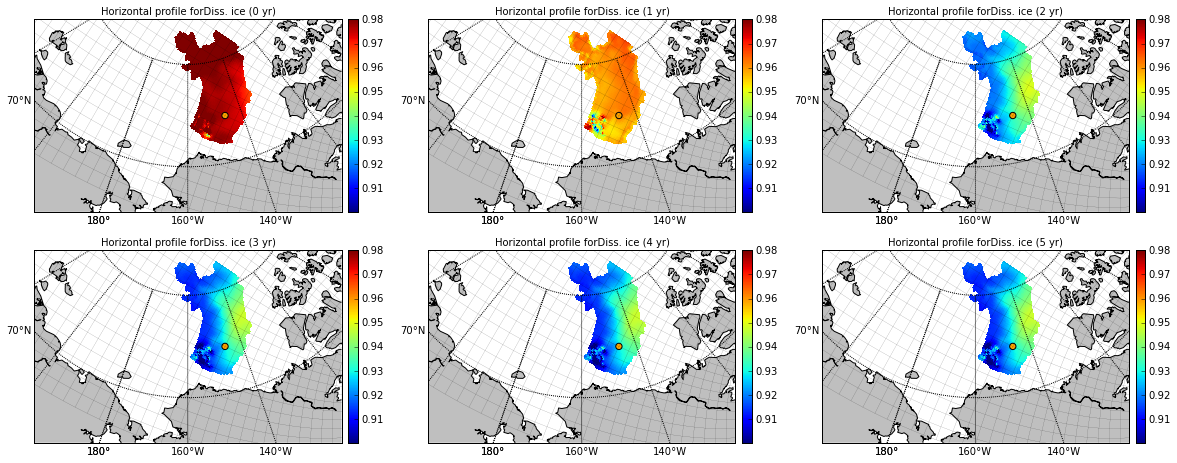

In [16]:
#plot ice profiles
data=readice('icePa',layer,a1,a2,b1,b2)

vmax=0.98#*(data[:,:,:]).max()
vmin=1.5*(data[:,:,:]).min()+0.9

print data[:,:,:].max()

plot_ratio('Diss','ice',data)

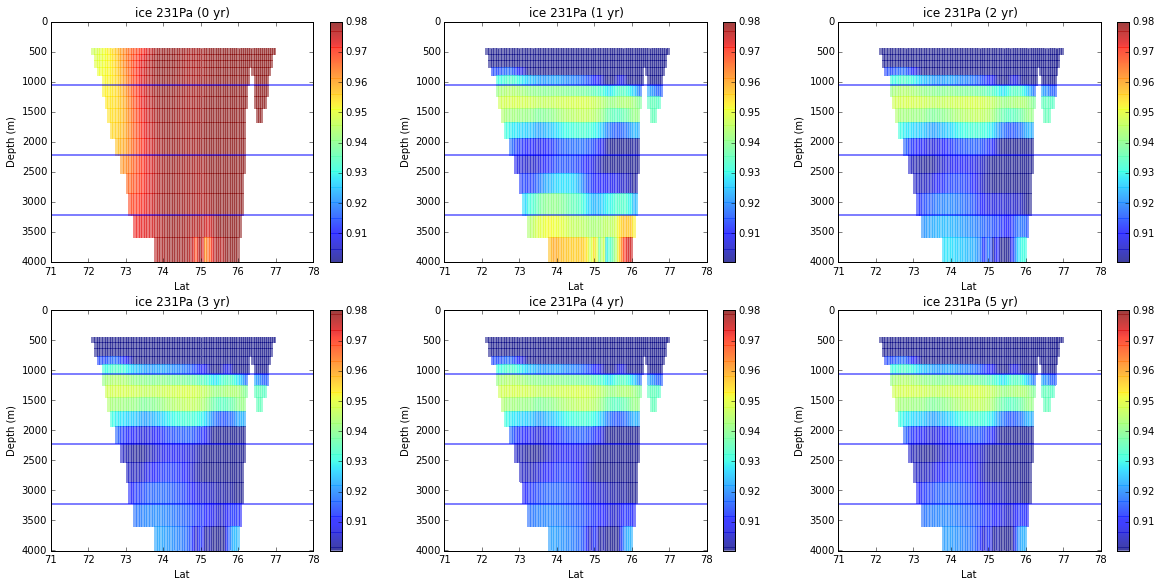

In [17]:
data=readice('icePa',i=0,a1=720,a2=721,b1=150,b2=250)

vmax=0.98#1*(data[:]).max()
vmin=1.2*(data[:]).min()+0.9

plot_vertical(lat=lat[700,150:250],data1=data, title1='ice 231Pa',vmin=vmin,vmax=vmax)

In [18]:
def plot_anal_vertical(lat,data1, title1,tag,lmin=30,lmax=46,ylim=[0,4000]):
    fig = plt.figure(figsize=(20,25))
    temp=np.zeros(data.shape)
    k=np.zeros(data.shape)
    if tag=='part. Pa':
        for i in range (len(data[1,0,0,:])):
            for j in range (len (data[1,:,0,0])):
                temp[:,j,0,i]=0.00246/(6.01*100*data[:,j,0,i]+500)*dep[j]
    if tag=='part. Th':
        for i in range (len(data[1,0,0,:])):
                for j in range (len (data[1,:,0,0])):
                    temp[:,j,0,i]=0.0267/(2.26*100*data[:,j,0,i]+500)*dep[j]
                    
    if tag=='diss. Pa':
        for i in range (len(data[1,0,0,:])):
            for j in range (len (data[1,:,0,0])):
                k[:,j,0,i]=-0.0005*100*data[:,j,0,i]+0.06
                temp[:,j,0,i]=0.00246/k[:,j,0,i]+0.31/k[:,j,0,i]*0.00246/(6.01*100*data[:,j,0,i]+500)*dep[j]

    if tag=='diss. Th':

        for i in range (len(data[1,0,0,:])):
            k_1=dsopt[0,i]
            for j in range (len (data[1,:,0,0])):
                k[:,j,0,i]=-0.0067*100*data[:,j,0,i]+0.75  
                temp[:,j,0,i]=0.0267/k[:,j,0,i]+k_1/k[:,j,0,i]*0.0267/(2.26*100*data[:,j,0,i]+500)*dep[j]

                
    temp=np.ma.masked_where(data<=0,temp)
    
    for num in range (tlen[0]/12):
        ax = fig.add_subplot(5,3,num+1)
        #print lat.shape,dep[lmin:lmax].shape,data1.shape,data1[num,lmin:lmax,0,:].shape
        if num==0:
            plt.pcolor(lat[:],dep[lmin:lmax],temp[1,lmin:lmax,0,:],alpha=0.5)
        else:
            plt.pcolor(lat[:],dep[lmin:lmax],temp[num,lmin:lmax,0,:],alpha=0.5)
        plt.colorbar()
        plt.ylim(ylim)
        plt.gca().invert_yaxis()
        plt.ylabel('Depth (m)')
        plt.xlabel('Lat')
        plt.title('%s (%s yr)'%(title1,num))
        plt.axhline(y=1062,c="blue",linewidth=2,alpha=0.5)
        plt.axhline(y=2225,c="blue",linewidth=2,alpha=0.5)
        plt.axhline(y=3220,c="blue",linewidth=2,alpha=0.5)
    plt.show()


/home/xiaoxiny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in divide


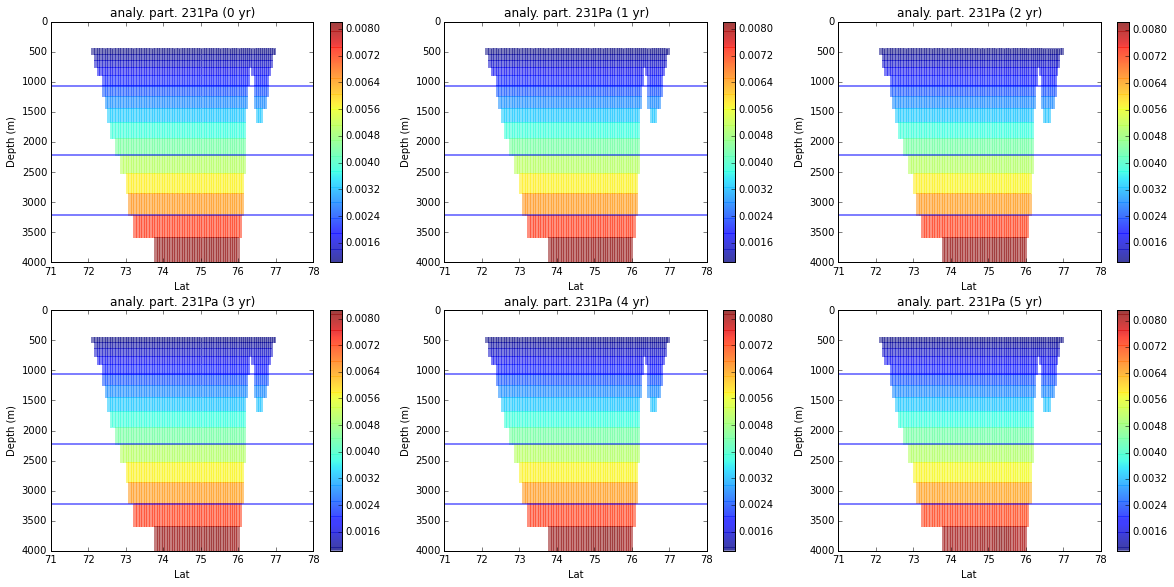

In [19]:
#analytical solution

data=readice('icePa',i=0,a1=720,a2=721,b1=150,b2=250)
plot_anal_vertical(lat=lat[700,150:250],data1=data, title1='analy. part. 231Pa',tag='part. Pa')

/home/xiaoxiny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in divide


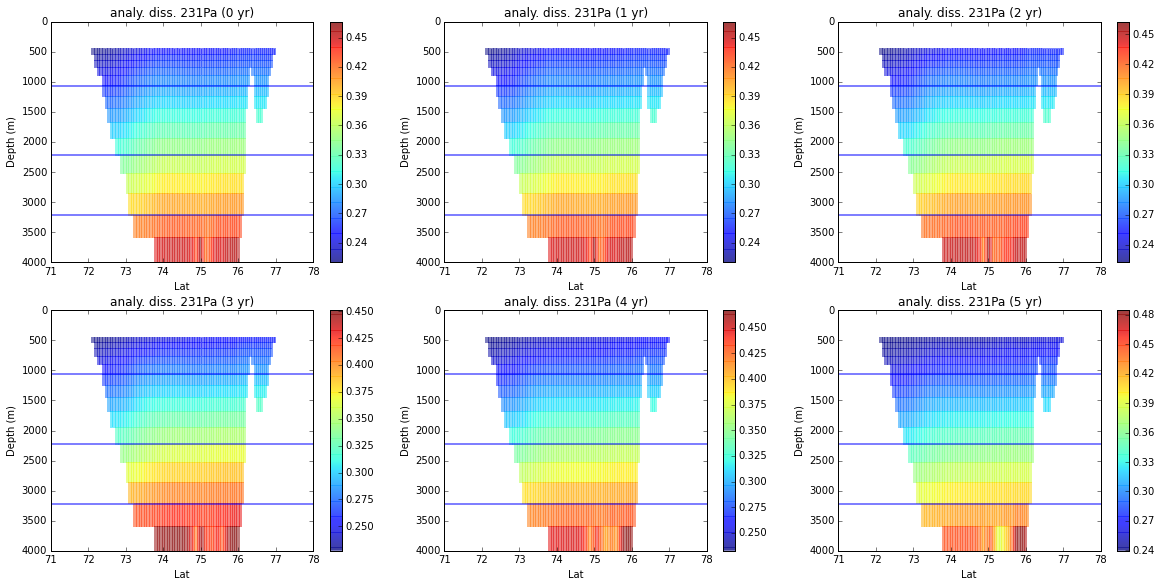

In [20]:
data=readice('icePa',i=0,a1=720,a2=721,b1=150,b2=250)
plot_anal_vertical(lat=lat[700,150:250],data1=data, title1='analy. diss. 231Pa',tag='diss. Pa')

In [21]:
data=readice('iceTh',i=0,a1=720,a2=721,b1=150,b2=250)
plot_anal_vertical(lat=lat[700,150:250],data1=data, title1='analy. diss. 231Th',tag='diss. Th')

NameError: global name 'dsopt' is not defined

# Focus on one tracer at one time

Note that these results are not yearly average. They are the monthly average from Dec in each year.

## Diss Pa  (horizontal, vertical, analytical vertical)

In [ ]:
data=readdata('diss','Pa',layer,a1,a2,b1,b2)

vmax=1*(data[:,:,:]).max()
vmin=1.5*(data[:,:,:]).min()+0.275

plot_ratio('Diss','231Pa',data)

In [ ]:
#plot vertical profiles
data=readdata('diss','Pa',i=0,a1=700,a2=701,b1=150,b2=250)

vmax=1*(data[:]).max()
vmin=1.2*(data[:]).min()

plot_vertical(lat=lat[700,150:250],data1=data, title1='diss 231Pa',vmin=vmin,vmax=vmax)

In [ ]:
#analytical
data=readice('icePa',i=0,a1=700,a2=701,b1=150,b2=250)
plot_anal_vertical(lat=lat[700,150:250],data1=data, title1='analy. diss. 231Pa',tag='diss. Pa')

## Diss Th  (horizontal, vertical, analytical vertical)

This part is confusing. According to the analytical solutuion, the concentration of diss. 230Th should increse but in the following plots we see 230Th decreases in value. (Alternertive explaination should be the circulation. However, juding from the ratio plots, I don't think it is the case.)

In [ ]:
data=readdata('diss','Th',layer,a1,a2,b1,b2)

vmax=1*(data[:,:,:]).max()
vmin=1.5*(data[:,:,:]).min()+0.2

plot_ratio('Diss','230Th',data)

In [ ]:
#plot vertical profiles
data=readdata('diss','Th',i=0,a1=700,a2=701,b1=150,b2=250)

vmax=0.8*(data[:]).max()
vmin=1.2*(data[:]).min()+0.05

plot_vertical(lat=lat[700,150:250],data1=data, title1='diss 230Th',vmin=vmin,vmax=vmax)

In [ ]:
#analytical vertical
a1=720;a2=721
b1=150;b2=250
Dsopt=nc.Dataset('/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/myANHA/EXP00/data_Th_desorption_rate.nc')
dsopt=Dsopt.variables['desorption_rate'][0,a1:a2,b1:b2]#(1, 800, 544)
data=readice('iceTh',i=0,a1=700,a2=701,b1=150,b2=250)
plot_anal_vertical(lat=lat[700,150:250],data1=data, title1='analy. diss. 230Th',tag='diss. Th')

## Part Pa  (horizontal, vertical, analytical vertical)

In [ ]:
data=readdata('part','Pa',layer,a1,a2,b1,b2)

vmax=0.6*(data[:,:,:]).max()
vmin=1.5*(data[:,:,:]).min()

plot_ratio('Part','231Pa',data)

print 'zoom in the 3rd and the 4th year'
string = 'Part'
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
m = Basemap(width =3345532*1,height =950905*2.2,lon_0=-160, lat_0=75,
                projection='stere', resolution='l',ax=ax1)
m.drawcoastlines()
m.fillcontinents(color = '0.75')
m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])
x_lon,y_lat = m(lon,lat)
m.plot(x_lon[::10,::10],y_lat[::10,::10],x_lon.T[::10,::10],y_lat.T[::10,::10],color='k',linewidth=0.1)
im = m.pcolor(x_lon[a1:a2,b1:b2],y_lat[a1:a2,b1:b2],data[36,:,:])
plt.colorbar(im, ax = ax1, fraction=0.03,pad=0.02)
plt.title('Horizontal profile for %s. 231Pa (3rd yr)'%string,fontsize=10)

ax1 = fig.add_subplot(122)
m = Basemap(width =3345532*1,height =950905*2.2,lon_0=-160, lat_0=75,
                projection='stere', resolution='l',ax=ax1)
m.drawcoastlines()
m.fillcontinents(color = '0.75')
m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])
x_lon,y_lat = m(lon,lat)
m.plot(x_lon[::10,::10],y_lat[::10,::10],x_lon.T[::10,::10],y_lat.T[::10,::10],color='k',linewidth=0.1)
im = m.pcolor(x_lon[a1:a2,b1:b2],y_lat[a1:a2,b1:b2],data[47,:,:])
plt.colorbar(im, ax = ax1, fraction=0.03,pad=0.02)
plt.title('Horizontal profile for %s. 231Pa (4th yr)'%string,fontsize=10)
plt.show()

In [ ]:
#plot vertical profiles
data=readdata('part','Pa',i=0,a1=700,a2=701,b1=150,b2=250)

vmax=0.4*(data[:]).max()
vmin=1.2*(data[:]).min()

plot_vertical(lat=lat[700,150:250],data1=data, title1='part 231Pa',vmin=vmin,vmax=vmax)

In [ ]:
data=readice('icePa',i=0,a1=700,a2=701,b1=150,b2=250)
plot_anal_vertical(lat=lat[700,150:250],data1=data, title1='analy. part. 231Pa',tag='part. Pa')

## Part Th  (horizontal, vertical, analytical vertical)

In [ ]:
data=readdata('part','Th',layer,a1,a2,b1,b2)

vmax=0.55*(data[:,:,:]).max()
vmin=1*(data[:,:,:]).min()+0.045

plot_ratio('Part','230Th',data)

In [ ]:
#plot vertical profiles
data=readdata('part','Th',i=0,a1=700,a2=701,b1=150,b2=250)

vmax=0.8*(data[:]).max()
vmin=1.2*(data[:]).min()+0.035

plot_vertical(lat=lat[700,150:250],data1=data, title1='part 230Th',vmin=vmin,vmax=vmax)

In [ ]:
data=readice('iceTh',i=0,a1=700,a2=701,b1=150,b2=250)
plot_anal_vertical(lat=lat[700,150:250],data1=data, title1='analy. part. 230Th',tag='part. Th')

# Somewhere besides Canada Basin

In [ ]:
a1=500
a2=660
b1=200
b2=400
layer=44

data1=readdata('diss','Pa',layer,a1,a2,b1,b2)
data2=readdata('diss','Th',layer,a1,a2,b1,b2)

data=data1[:,:,:]/data2[:,:,:]

vmax=0.35*(data1[:,:,:]/data2[:,:,:]).max()
vmin=1*(data1[:,:,:]/data2[:,:,:]).min()

plot_ratio2('Diss','231Pa/230Th',data)

In [ ]:
#blue point
data1=readdata('diss','Pa',i=0,a1=600,a2=601,b1=320,b2=400)
data2=readdata('diss','Th',i=0,a1=600,a2=601,b1=320,b2=400)
data=data1[:]/data2[:]

vmax=0.7*(data[:]).max()
vmin=1*(data[:]).min()

plot_vertical(lat=lat[600,320:400],data1=data, title1='diss 231Pa/230Th',vmin=vmin,vmax=vmax)

In [ ]:
data1=readdata('part','Pa',layer,a1,a2,b1,b2)
data2=readdata('part','Th',layer,a1,a2,b1,b2)

vmax=0.35*(data1[:,:,:]/data2[:,:,:]).max()
vmin=1.2*(data1[:,:,:]/data2[:,:,:]).min()

data=data1[:,:,:]/data2[:,:,:]

plot_ratio2('Part','231Pa/230Th',data)

In [ ]:
#blue point
data1=readdata('part','Pa',i=0,a1=600,a2=601,b1=320,b2=400)
data2=readdata('part','Th',i=0,a1=600,a2=601,b1=320,b2=400)
data=data1[:]/data2[:]

vmax=0.6*(data[:]).max()
vmin=1.5*(data[:]).min()

plot_vertical(lat=lat[600,320:400],data1=data, title1='part 231Pa/230Th',vmin=vmin,vmax=vmax)

In [ ]:
data=readdata('diss','Pa',layer,a1,a2,b1,b2)

vmax=1*(data[:,:,:]).max()
vmin=1.5*(data[:,:,:]).min()+0.275

plot_ratio2('Diss','231Pa',data)

In [ ]:
#blue point
data=readdata('diss','Pa',i=0,a1=600,a2=601,b1=320,b2=400)


vmax=1*(data[:]).max()
vmin=1.5*(data[:]).min()+0.275

plot_vertical(lat=lat[600,320:400],data1=data, title1='diss 231Pa',vmin=vmin,vmax=vmax)

In [ ]:
data=readdata('diss','Th',layer,a1,a2,b1,b2)

vmax=1*(data[:,:,:]).max()
vmin=1.5*(data[:,:,:]).min()+0.2

plot_ratio2('Diss','230Th',data)


In [ ]:
#blue point

data=readdata('diss','Th',i=0,a1=600,a2=601,b1=320,b2=400)

vmax=1*(data[:]).max()
vmin=1.2*(data[:]).min()+0.2

plot_vertical(lat=lat[600,320:400],data1=data, title1='diss 230Th',vmin=vmin,vmax=vmax)

In [ ]:
data=readdata('part','Pa',layer,a1,a2,b1,b2)

vmax=0.55*(data[:,:,:]).max()
vmin=1.5*(data[:,:,:]).min()+0.01

plot_ratio2('Part','231Pa',data)

In [ ]:
data=readdata('part','Pa',i=0,a1=600,a2=601,b1=320,b2=400)

vmax=0.8*(data[:]).max()
vmin=1.2*(data[:]).min()+0.007

plot_vertical(lat=lat[600,320:400],data1=data, title1='part 231Pa',vmin=vmin,vmax=vmax)

In [ ]:
data=readdata('part','Th',layer,a1,a2,b1,b2)

vmax=0.4*(data[:,:,:]).max()
vmin=1*(data[:,:,:]).min()+0.13

plot_ratio2('Part','230Th',data)

In [ ]:
data=readdata('part','Th',i=0,a1=600,a2=601,b1=320,b2=400)

vmax=0.8*(data[:]).max()
vmin=1.2*(data[:]).min()+0.03

plot_vertical(lat=lat[600,320:400],data1=data, title1='part 230Th',vmin=vmin,vmax=vmax)

### Take a look at the vertical profiles of scavenging parameters

In [ ]:
#nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/tracer6/newsms/fse3t_based_mask/*ptrc*.nc'))
#print("found *.nc file: \n{}".format(nc_filename))

ptrc=nc.Dataset(nc_filename[0])
dep=ptrc.variables['deptht'][:]
lon=ptrc.variables['nav_lon'][:]
lat=ptrc.variables['nav_lat'][:]

TR_7=ptrc.variables['TR_7'][-1,:,:,:]
TR_8=ptrc.variables['TR_8'][-1,:,:,:]
TR_9=ptrc.variables['TR_9'][-1,:,:,:]
TR_10=ptrc.variables['TR_10'][-1,:,:,:]
TR_11=ptrc.variables['TR_11'][-1,:,:,:]
TR_12=ptrc.variables['TR_12'][-1,:,:,:]

TR_8=np.ma.masked_where(TR_7<= 0, TR_8)
TR_9=np.ma.masked_where(TR_7<= 0, TR_9)
TR_10=np.ma.masked_where(TR_7<= 0, TR_10)
TR_11=np.ma.masked_where(TR_7<= 0, TR_11)
TR_12=np.ma.masked_where(TR_7<= 0, TR_12)
#finally  masked TR7
TR_7=np.ma.masked_where(TR_7<= 0, TR_7)

In [ ]:
fig = plt.figure(figsize=(10,10))
#gs = gridspec.GridSpec(3, 3)
ax = fig.add_subplot()
m = Basemap(projection='npstere',boundinglat=65,lon_0=0,resolution='l')
m.drawcoastlines()
m.fillcontinents(color = '0.75')
m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])
x_lon,y_lat = m(lon,lat)
plt.plot(x_lon[::10,::10],y_lat[::10,::10],x_lon.T[::10,::10],y_lat.T[::10,::10],color='k',linewidth=0.1)
x=[700,630,600]
y=[200,300,350]
c=['orange','red','cyan']
m.scatter(x_lon[x,y],y_lat[x,y],color=c,s=40)
m.plot(x_lon[700,150:250],y_lat[700,150:250],color='orange')
m.plot(x_lon[615:650,300],y_lat[615:650,300],color='red')
m.plot(x_lon[600,320:400],y_lat[600,320:400],color='blue')
#m = m.contour(x_lon,y_lat,bathy,linewidth=0.075,colors='black',alpha=0.4)
#plt.clabel(m, fontsize=10, inline=1,fmt = '%1.0f')
plt.show()

In [ ]:
def verticalplot(lat,data1, title1,data2,title2,lmin=30,lmax=46,ylim=[0,4000]):
    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot(1,2,1)
    plt.contourf(lat[:],dep[lmin:lmax],data1[lmin:lmax,:],alpha=0.5)
    plt.colorbar()
    plt.ylim(ylim)
    plt.gca().invert_yaxis()
    plt.ylabel('Depth (m)')
    plt.xlabel('Lat')
    plt.title('%s'%title1)
    plt.axhline(y=1062,c="blue",linewidth=2,alpha=0.5)
    plt.axhline(y=2225,c="blue",linewidth=2,alpha=0.5)
    plt.axhline(y=3220,c="blue",linewidth=2,alpha=0.5)

    ax = fig.add_subplot(1,2,2)
    plt.contourf(lat[:],dep[lmin:lmax],data2[lmin:lmax,:],alpha=0.5)
    plt.colorbar()
    plt.ylim(ylim)
    plt.gca().invert_yaxis()
    plt.ylabel('Depth (m)')
    plt.xlabel('Lat')
    plt.title('%s'%title2)
    plt.axhline(y=1062,c="blue",linewidth=2,alpha=0.5)
    plt.axhline(y=2225,c="blue",linewidth=2,alpha=0.5)
    plt.axhline(y=3220,c="blue",linewidth=2,alpha=0.5)

    plt.show()

# at the last month

In [ ]:
sPa=6.01*100*TR_11+500
sTh=2.26*100*TR_12+500

verticalplot(lat=lat[700,150:250],data1=sPa[:,700,150:250], title1='singking 231Pa',data2=sTh[:,700,150:250],title2='sinking 230Th')

In [ ]:
verticalplot(lat=lat[615:650,300],data1=sPa[:,615:650,300], title1='singking 231Pa',data2=sTh[:,615:650,300],title2='sinking 230Th')

In [ ]:
verticalplot(lat=lat[600,320:400],data1=sPa[:,600,320:400], title1='singking 231Pa',data2=sTh[:,600,320:400],title2='sinking 230Th')